<center> <h1> Enhanced Index Tracking with Distributionally Robust Optimization <h1/> <center/>

## Imports

In [1]:
import sys
import os
import re
import glob
import datetime as dt
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mosek.fusion import *
from tqdm import tqdm
import time
import scipy.stats as sps

In [2]:
from EITP.Models.Model1 import IndexTracker as firstModel;
from EITP.Models.Model1DRO import IndexTracker as firstModelDRO;
from EITP.Models.EWCVaR import IndexTracker as EWCVaR;
from EITP.Backtesting.VisualComparison import Visualizer;
from EITP.Backtesting.QuantitativeComparison import PerformanceMetrics;

## Choose Data Set

In [3]:
# Choose from 
# 1. DD
# 2. DU
# 3. UD
# 4. UU

whichData = "DU";

## Model Controller

In [4]:
# Enhanced returns
alphaAnnualy = 0.0510;
alphaWeekly = (1 + alphaAnnualy)**(1/52) - 1;

# Generic controls
shortingCapacity = 0.00;
selectBeta = [0.95];
selectGamma = [0];

# DRO controls
selectedEpsilon = 10**(-0.8);
lowerEps = 10**(-16);
upperEps = 10**(-0.5);
epsCollection = np.linspace(lowerEps, upperEps, 100);
selectedEpsilonIndex = np.argmin([(i - selectedEpsilon)**(2) for i in epsCollection]);

## Plot Settings

In [5]:
OoS_ylimits = [95,160];

## Load Training and Test Data

In [6]:
inSample = pd.read_csv("./Data/Data from Guastaroba (2020)/CSV/IS-GMS-{}.csv".format(whichData), header=None);
outSample = pd.read_csv("./Data/Data from Guastaroba (2020)/CSV/OoS-GMS-{}.csv".format(whichData), header=None);

# Out-of-sample data is in levels
IndexOoS = outSample.pct_change();
IndexOoS = IndexOoS.values[:,0]
IndexOoS = IndexOoS[1:];
AssetsOoS = outSample.pct_change();
AssetsOoS = AssetsOoS.values[:,1:]
AssetsOoS = AssetsOoS[1:];

# In-sample data is in returns
IndexIS = inSample.iloc[:,0].values
AssetsIS = inSample.iloc[:,1:].values

## Parameter Estimation

In [7]:
# Train Base Model
M1 = firstModel(returnsAssets=AssetsIS, returnsIndex=IndexIS, betas=[0.95], gammas=[0.0], shortingCapacity=0.0, alphaAnnualy=alphaAnnualy);
M1.solve();

# Train Base Model with DRO
M1DRO = firstModelDRO(returnsAssets=AssetsIS, returnsIndex=IndexIS, betas=[0.95], gammas=[0.0], shortingCapacity=0.0, alphaAnnualy=alphaAnnualy);
M1DRO.solve(epsCollection=[selectedEpsilon]);

# Train EWCVaR
EWCVaR1 = EWCVaR(returnsAssets=AssetsIS, returnsIndex=IndexIS, shortingCapacity=0.0, alphaAnnualy=alphaAnnualy);
EWCVaR1.solve([0.05, 0.25, 0.50]);

100%|███████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.34it/s]


<center> <h1>Testing of Package 'EITP'<h1/> <center/>

# Visual Comparison

### 1) Base Model

Start by instantiating the model.

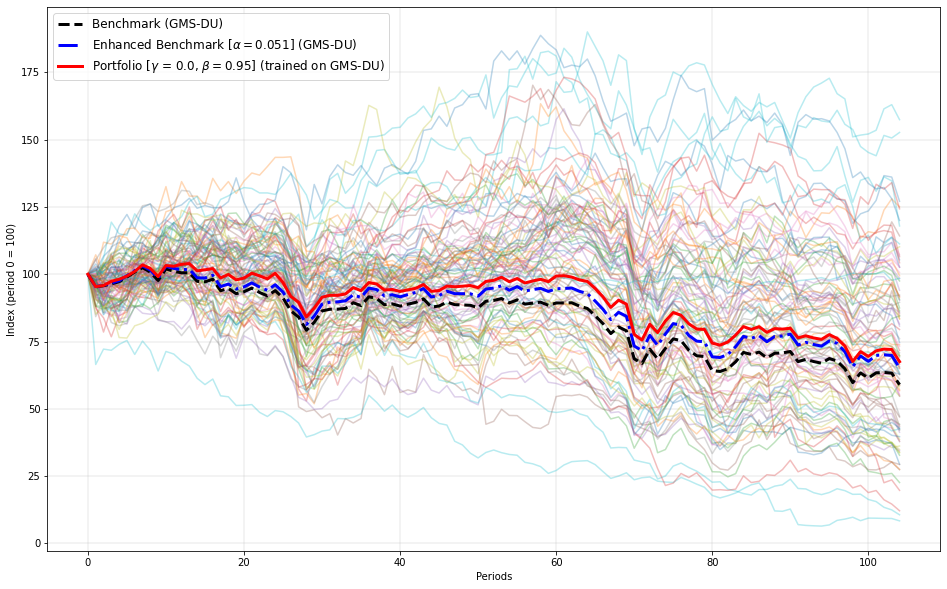

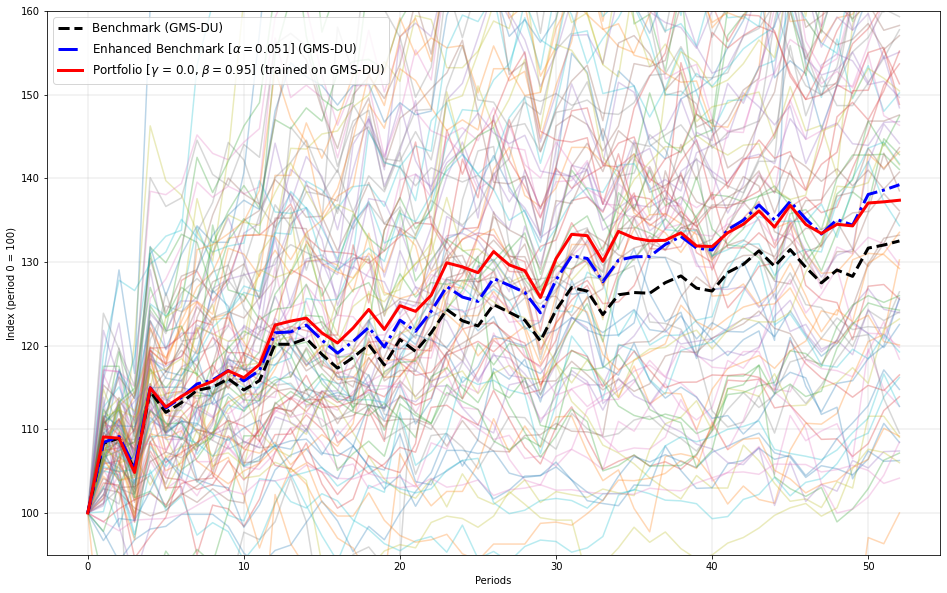

In [8]:
# Show in-sample performance visually
assetsM1_IS, indexM1_IS, enhancedIndexM1_IS, portfolioM1_IS = M1.IS(saveFile="Base_IS_{}".format(whichData), dataName="GMS-{}".format(whichData), plot=True);

# Show out-of-sample performance visually
assetsM1_OoS, indexM1_OoS, enhancedIndexM1_OoS, portfolioM1_OoS = M1.OoS(AssetsOoS, IndexOoS, saveFile="Base_OoS_{}".format(whichData), dataName="GMS-{}".format(whichData), plot=True, ylim=OoS_ylimits);

### 2) Base Model with DRO

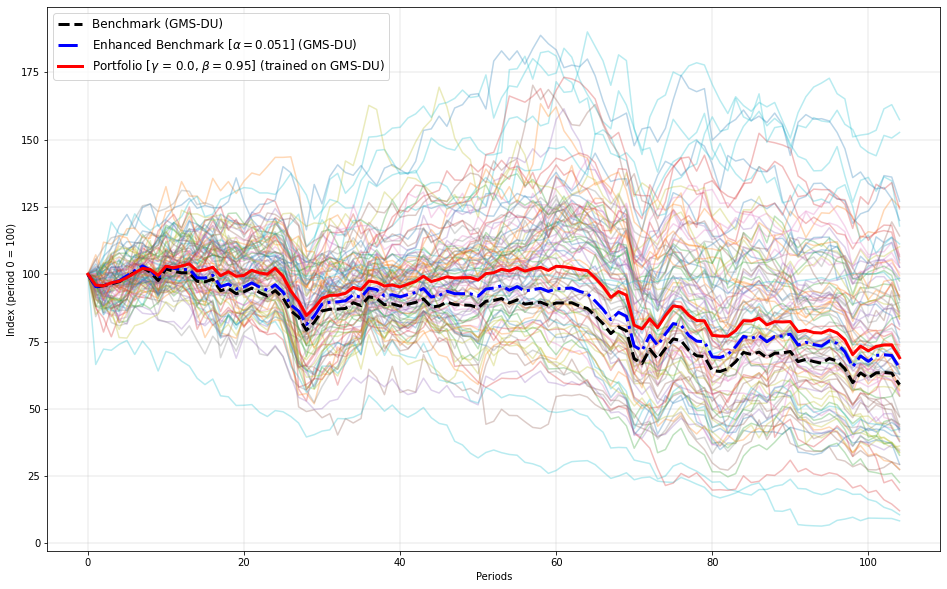

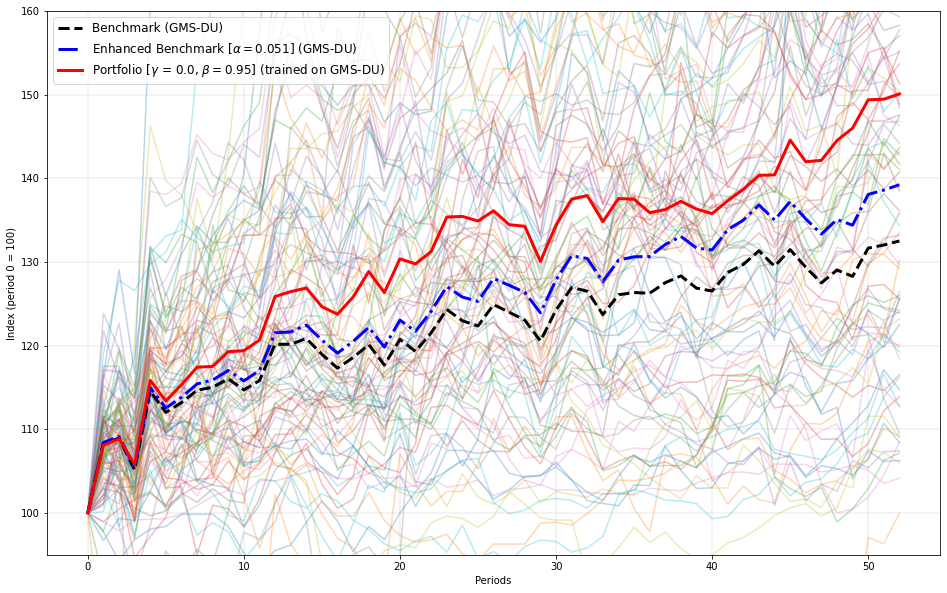

In [9]:
# Show in-sample performance visually
assetsM1DRO_IS, indexM1DRO_IS, enhancedIndexM1DRO_IS, portfolioM1DRO_IS = M1DRO.IS(saveFile="BaseDRO_IS_{}".format(whichData), dataName="GMS-{}".format(whichData), plot=True);

# Show out-of-sample performance visually
assetsM1DRO_OoS, indexM1DRO_OoS, enhancedIndexM1DRO_OoS, portfolioM1DRO_OoS = M1DRO.OoS(AssetsOoS, IndexOoS, saveFile="BaseDRO_OoS_".format(whichData), dataName="GMS-{}".format(whichData), plot=True, ylim=OoS_ylimits);

### 3) EWCVaR

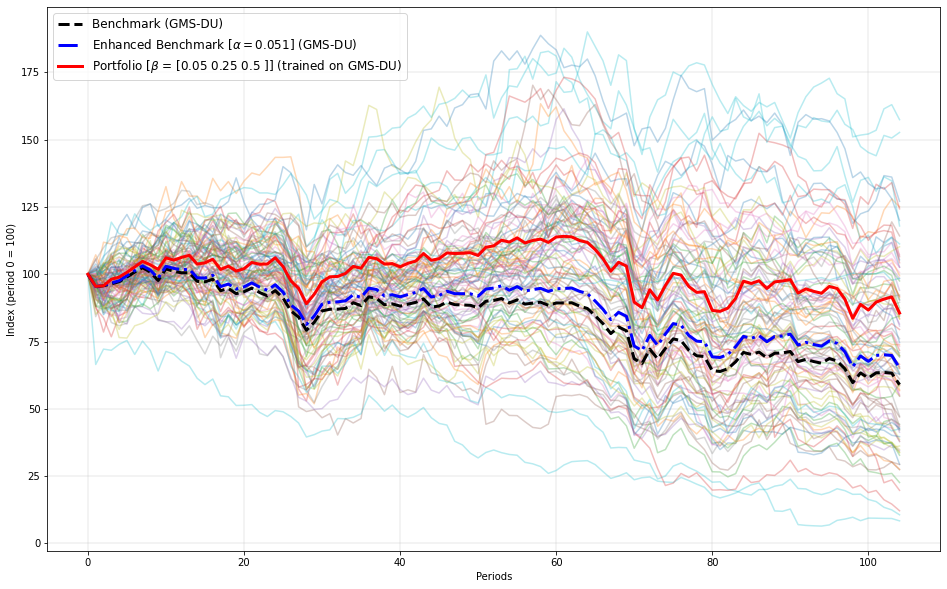

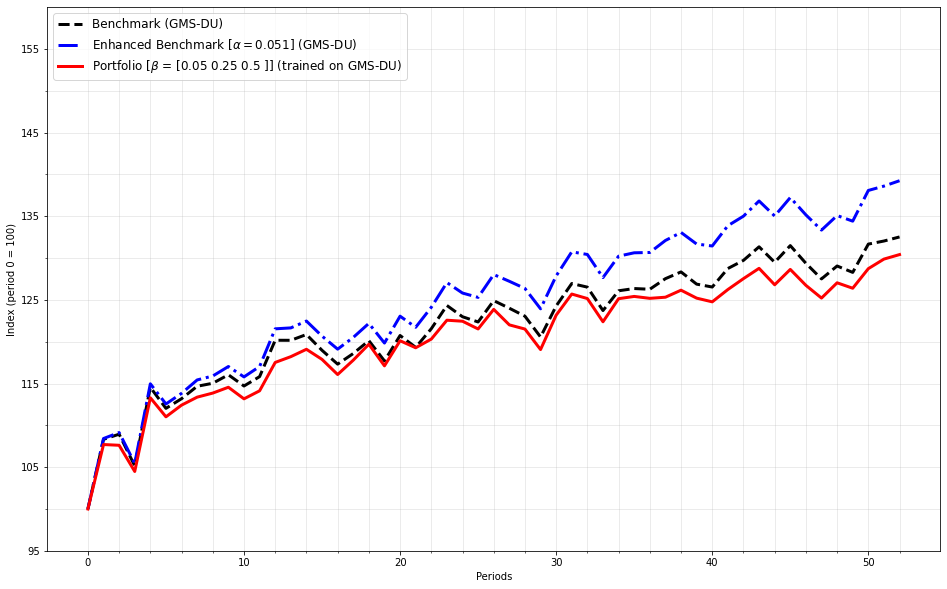

In [10]:
# Show in-sample performance visually
assetsEWCVaR1_IS, indexEWCVaR1_IS, enhancedIndexEWCVaR1_IS, portfolioEWCVaR1_IS = EWCVaR1.IS(saveFile="EWCVaR_IS_{}".format(whichData), dataName="GMS-{}".format(whichData), plot=True, updateWeights=False);

# Show out-of-sample performance visually
assetsEWCVaR1_OoS, indexEWCVaR1_OoS, enhancedIndexEWCVaR1_OoS, portfolioEWCVaR1_OoS = EWCVaR1.OoS(AssetsOoS, IndexOoS, saveFile="EWCVaR_OoS_{}".format(whichData), dataName="GMS-{}".format(whichData), plot=True, ylim=OoS_ylimits, updateWeights=False);

### 4) Comparison of Methods

In [11]:
# Structure input data (assets, index, enhancedIndex is the same for all models)
portfolios = {'BaseModel': portfolioM1_OoS, 'BaseModelDRO': portfolioM1DRO_OoS, 'EWCVaR': portfolioEWCVaR1_OoS};
assets = assetsM1DRO_OoS;
index = indexM1DRO_OoS;
enhancedIndex = enhancedIndexM1DRO_OoS;

In [12]:
# Create a visualization environment
testEnvironmentOoS = Visualizer(portfolios, assets, index, enhancedIndex, dataSet="GMS-{}".format(whichData));

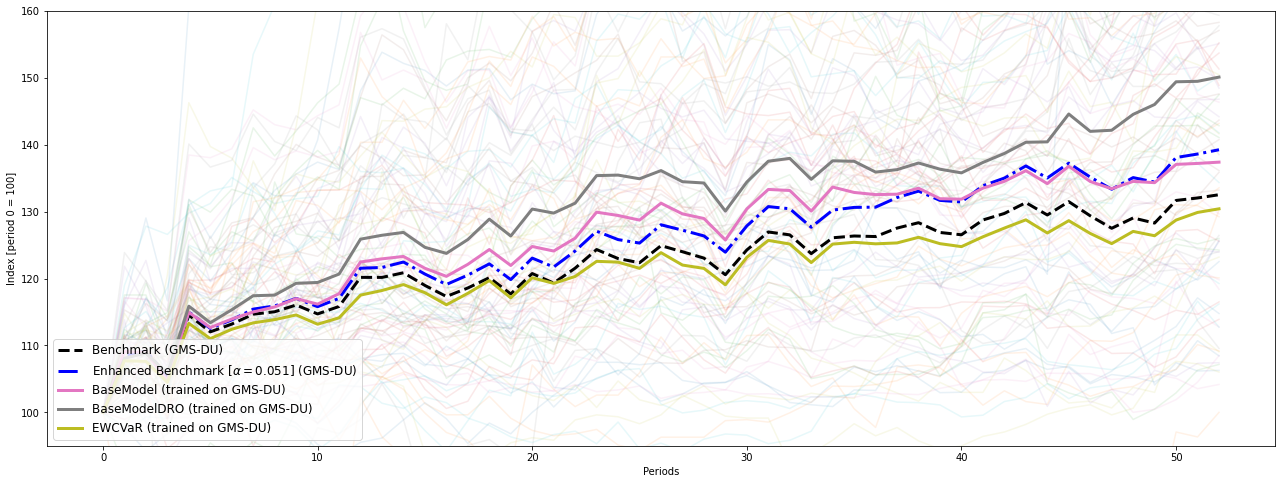

In [13]:
# Compare all models
testEnvironmentOoS.compareTracking(fileName="OoS_comparison_basic_{}".format(whichData), extended=False, opacity=0.1, size=(22,8), firstylim=OoS_ylimits)

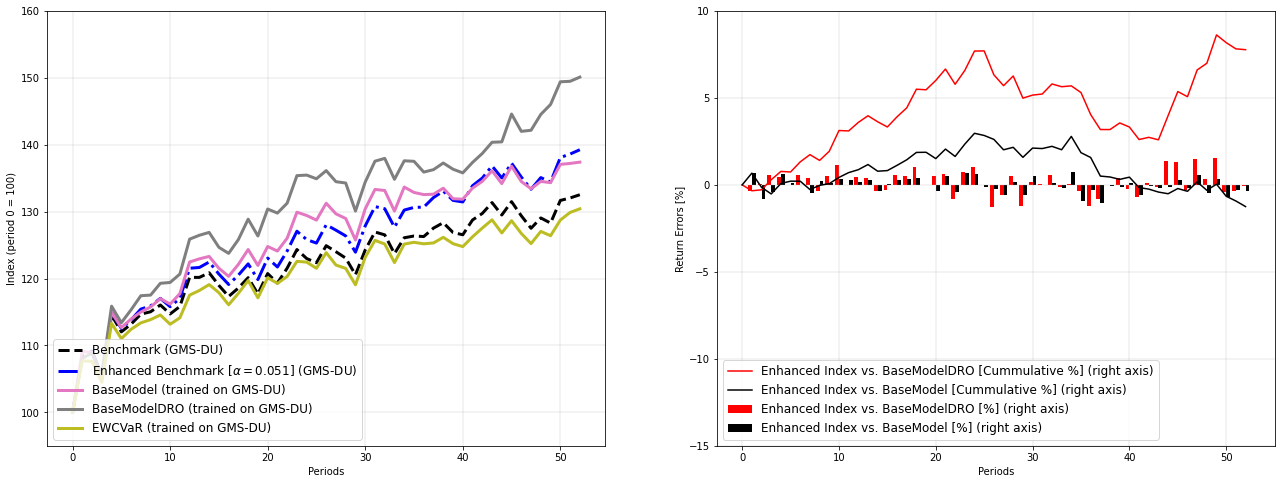

In [21]:
# Compare all models
testEnvironmentOoS.compareTracking(fileName="OoS_comparison_{}".format(whichData), extended=True, opacity=0.0, size=(22,8), firstylim=OoS_ylimits, ylim=[-15,10], compareModels=['BaseModelDRO', 'BaseModel'])

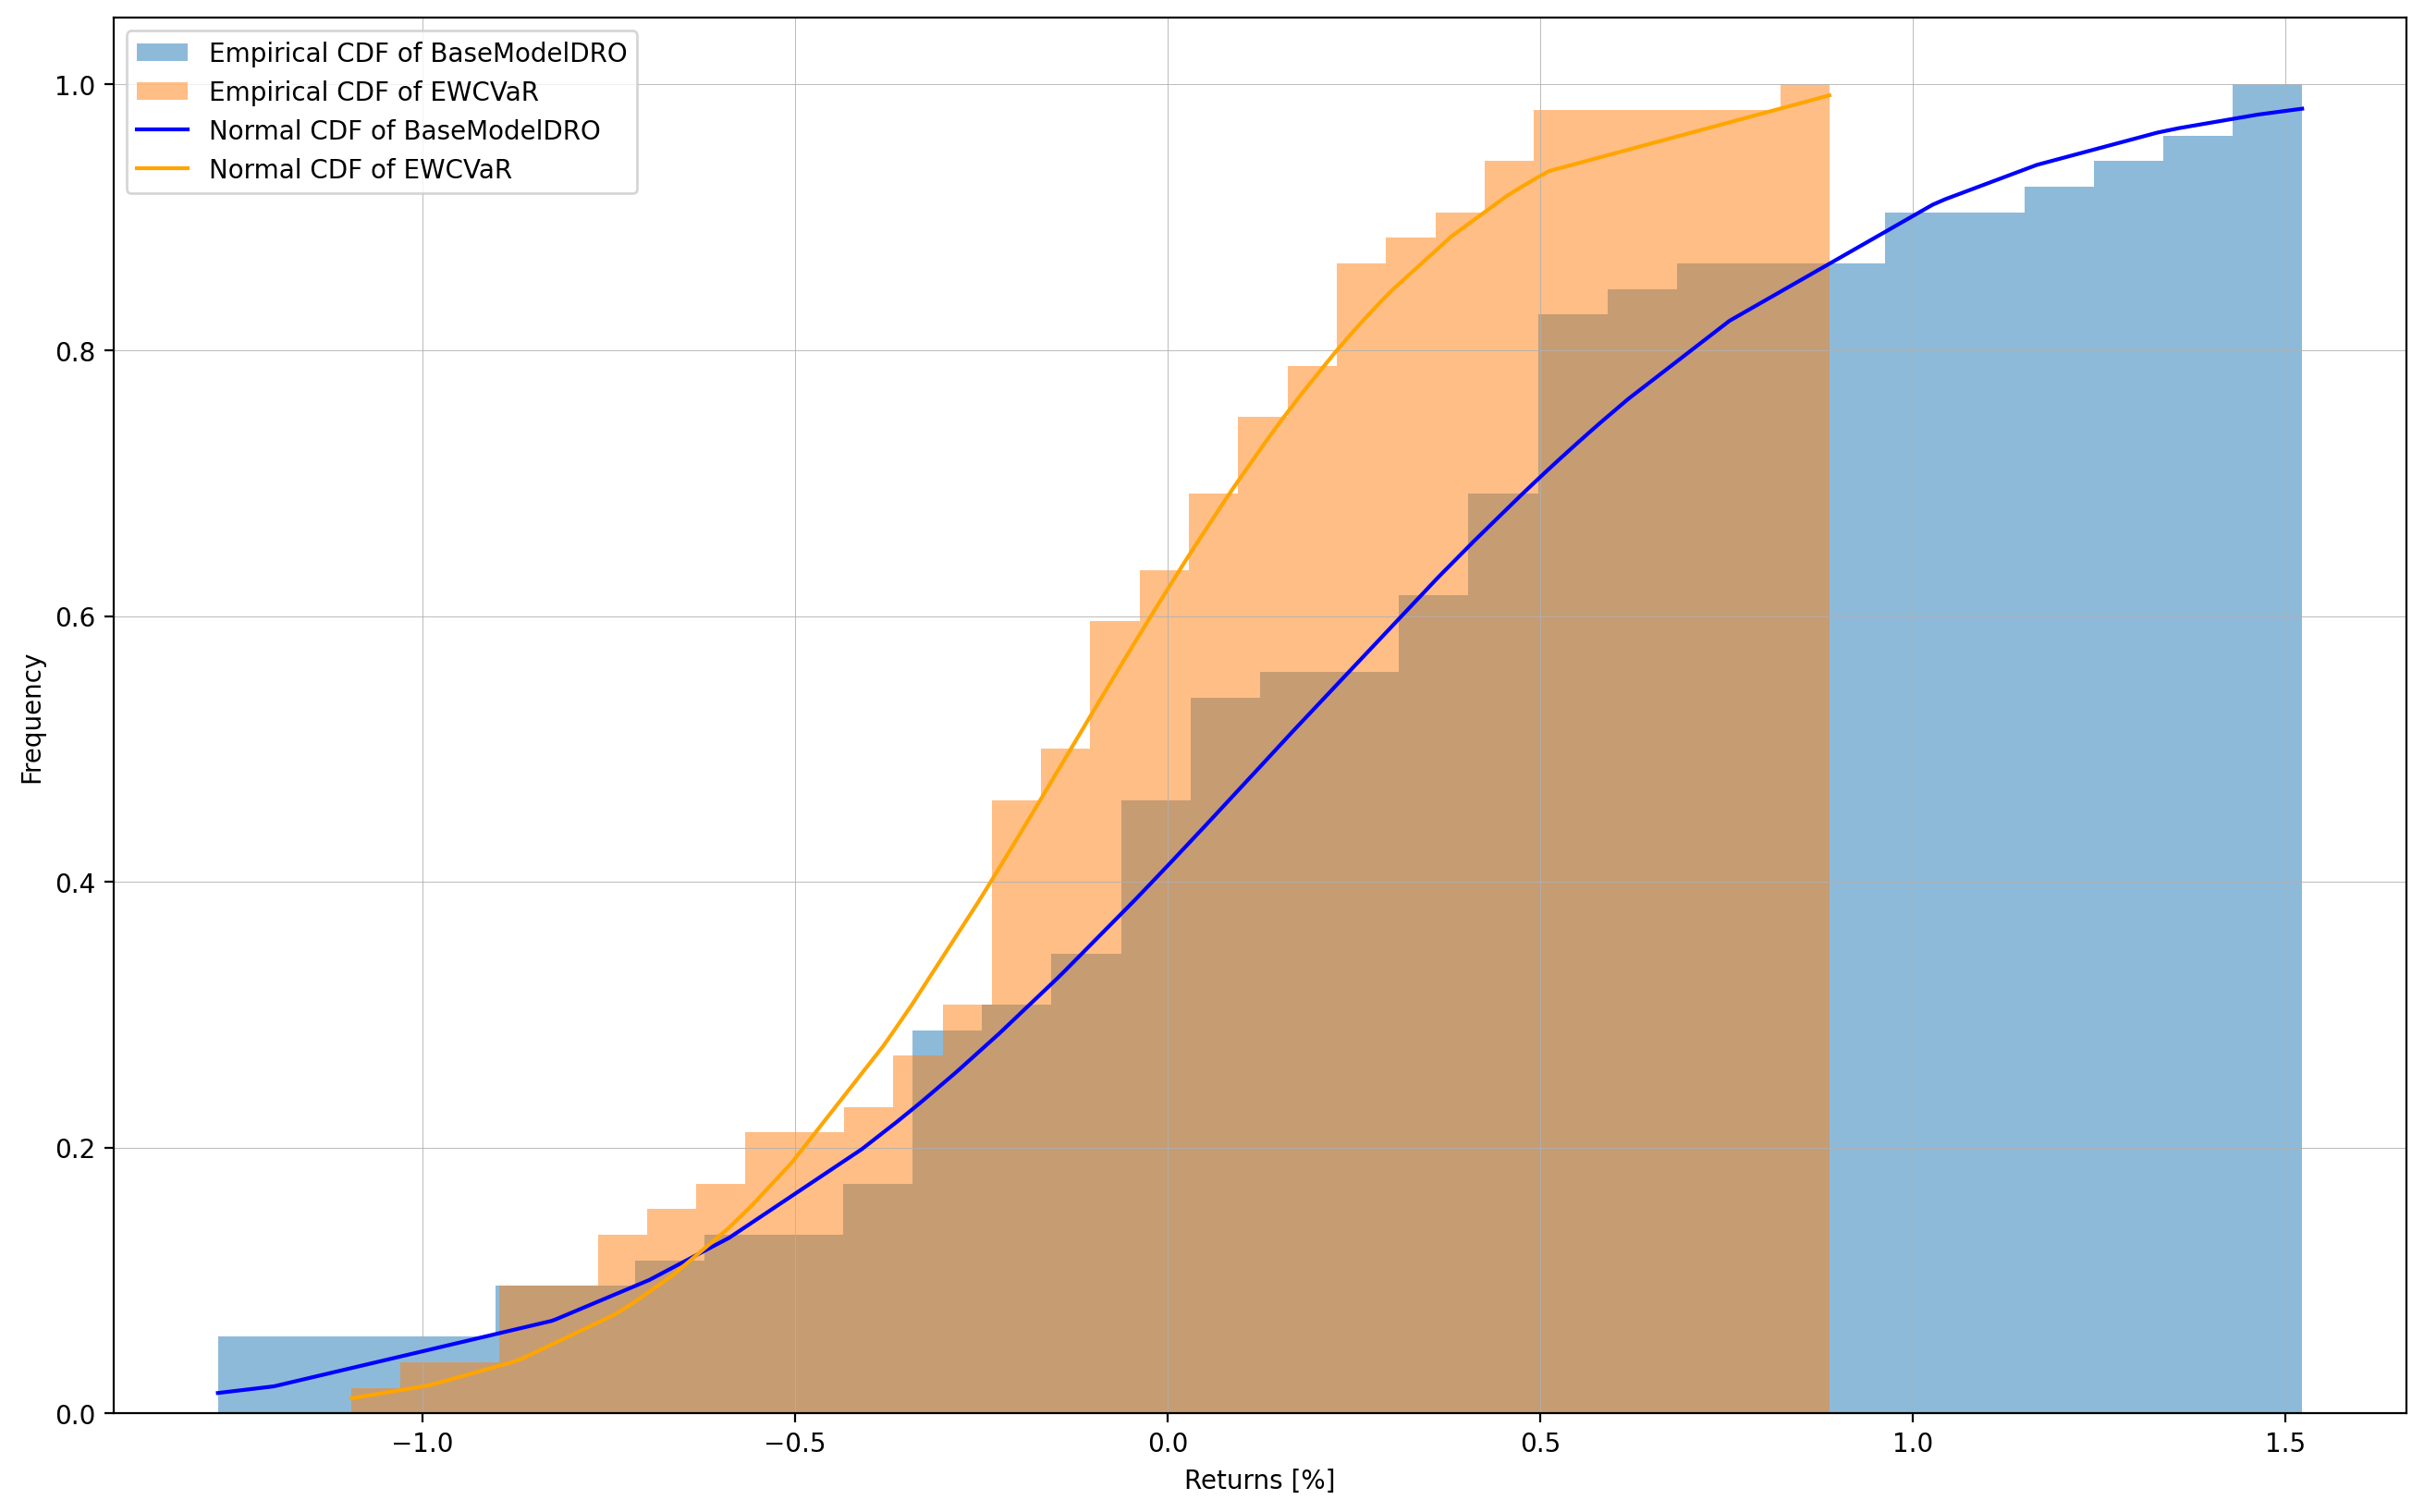

In [15]:
testEnvironmentOoS.compareDistributions('BaseModelDRO', 'EWCVaR', fileName="Comparison_EWCVaR_BaseModelDRO_{}".format(whichData))

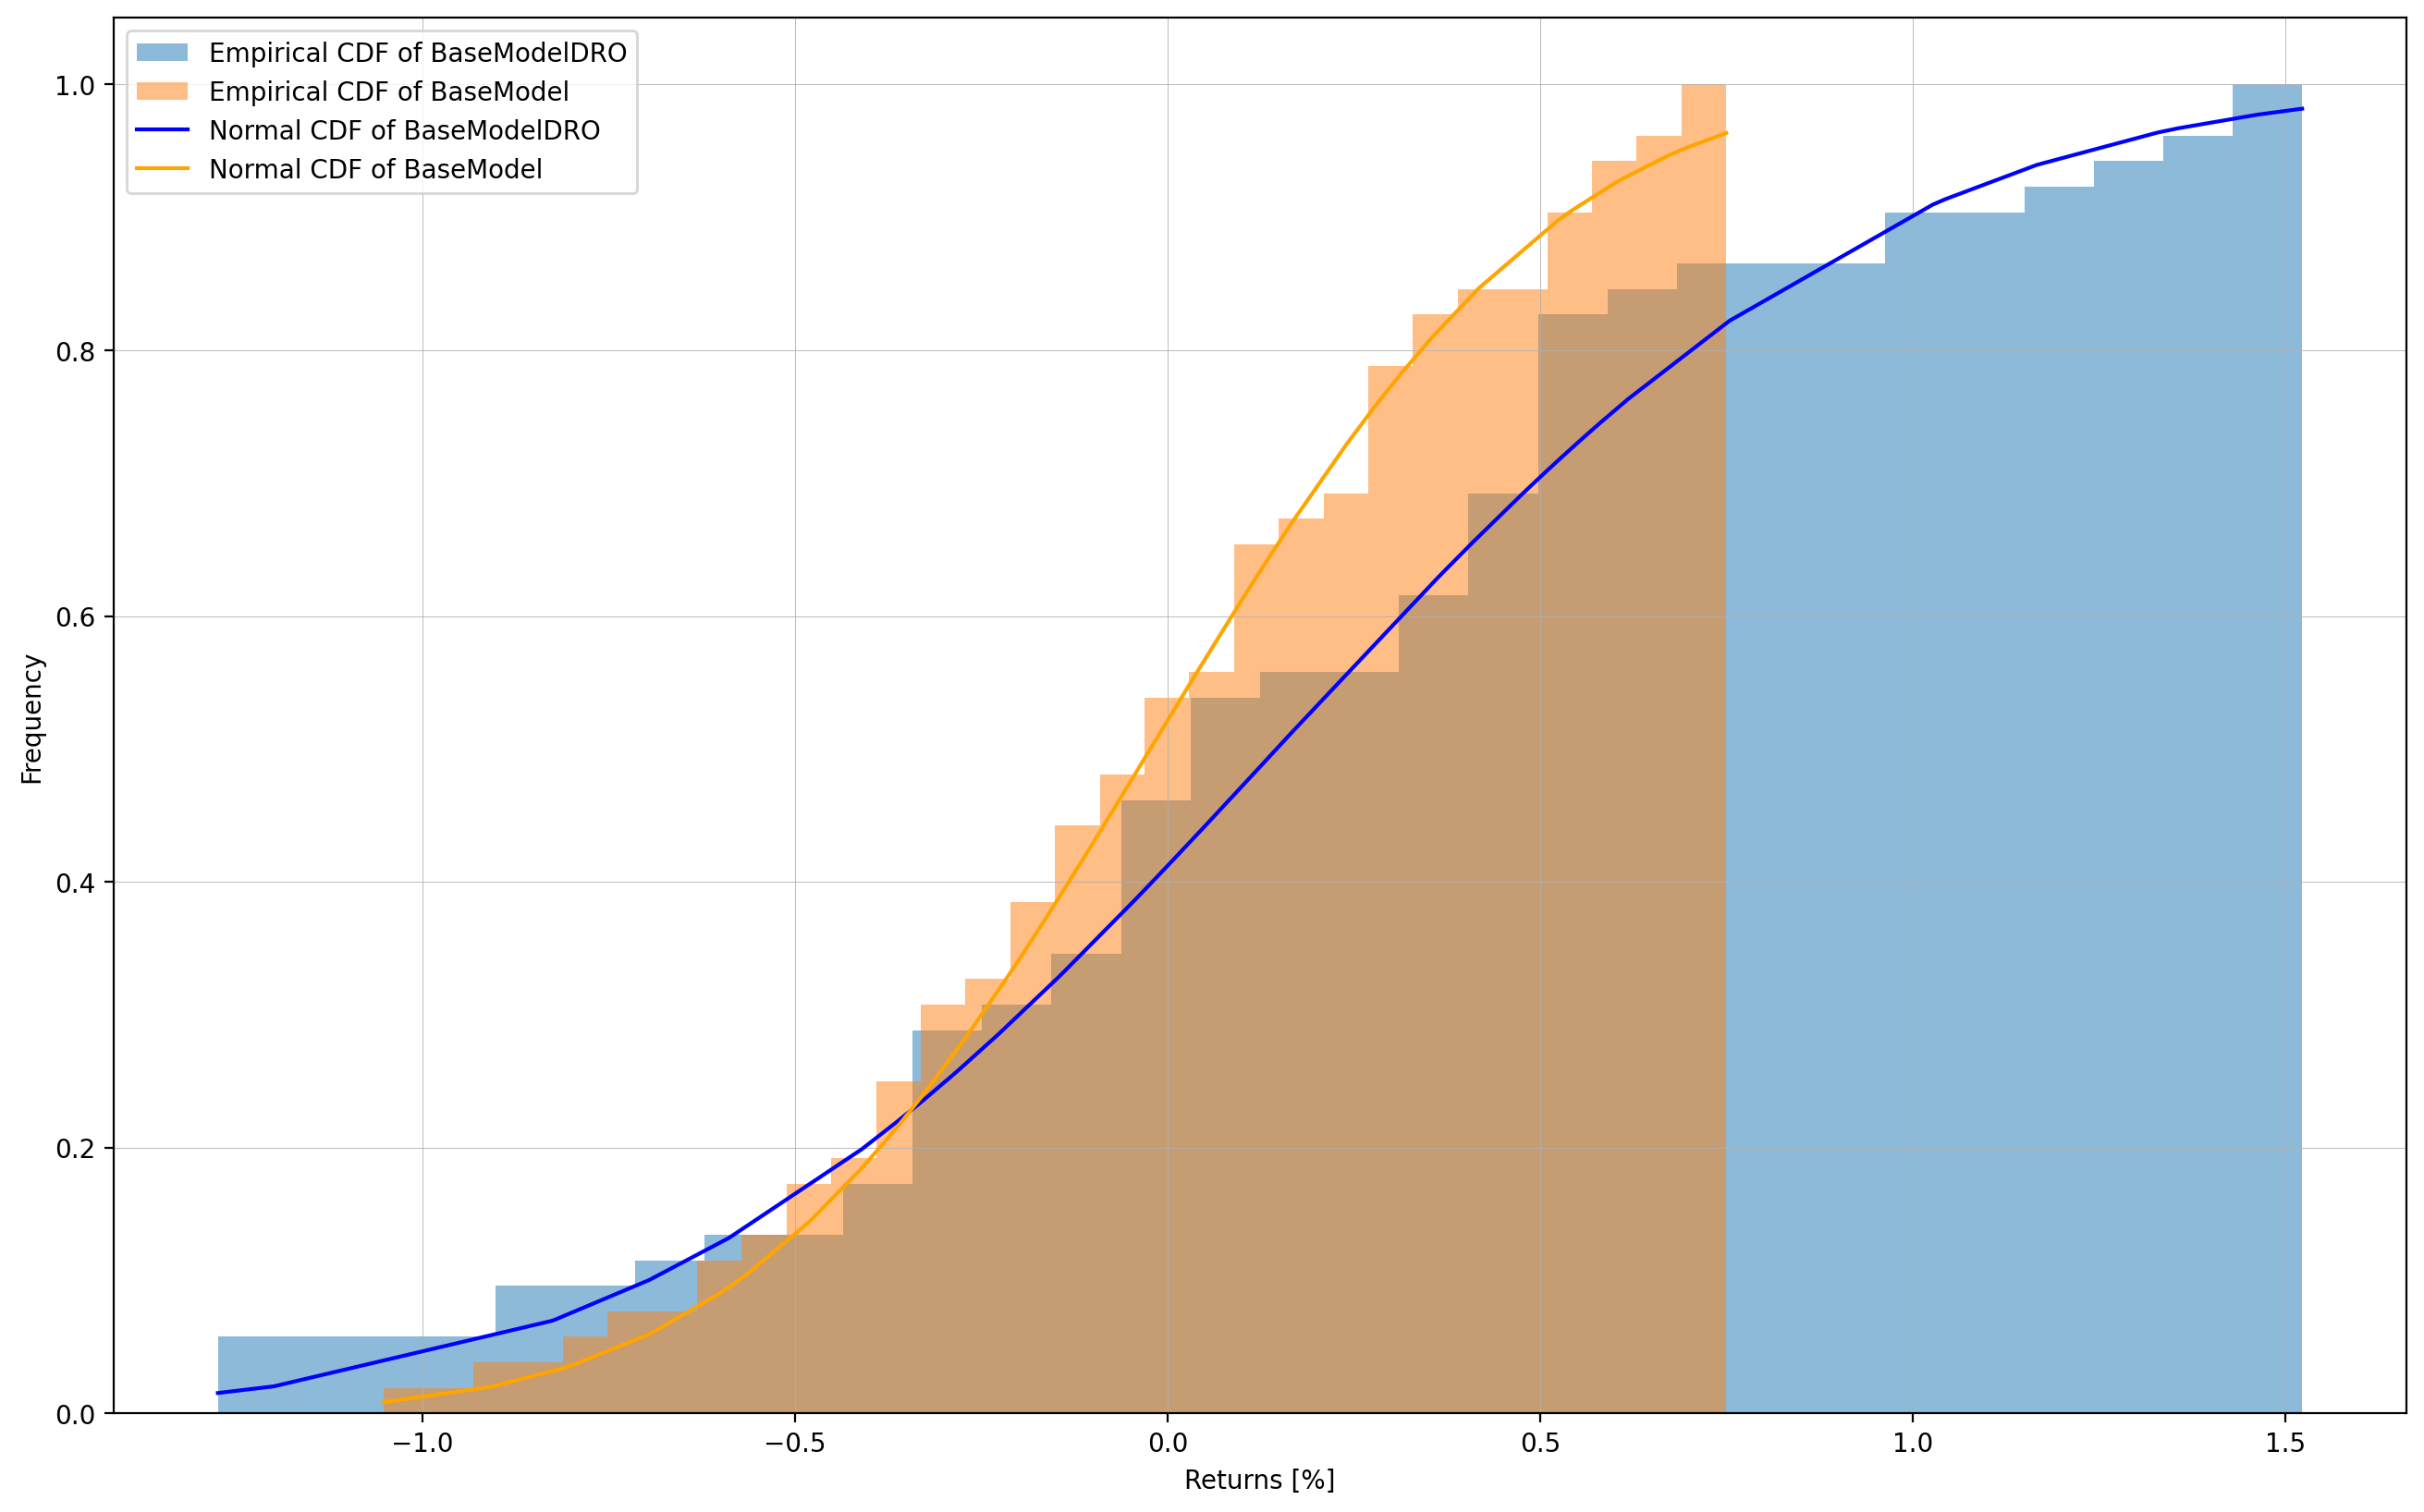

In [16]:
testEnvironmentOoS.compareDistributions('BaseModelDRO', 'BaseModel', fileName="Comparison_BaseModel_BaseModelDRO_{}".format(whichData))

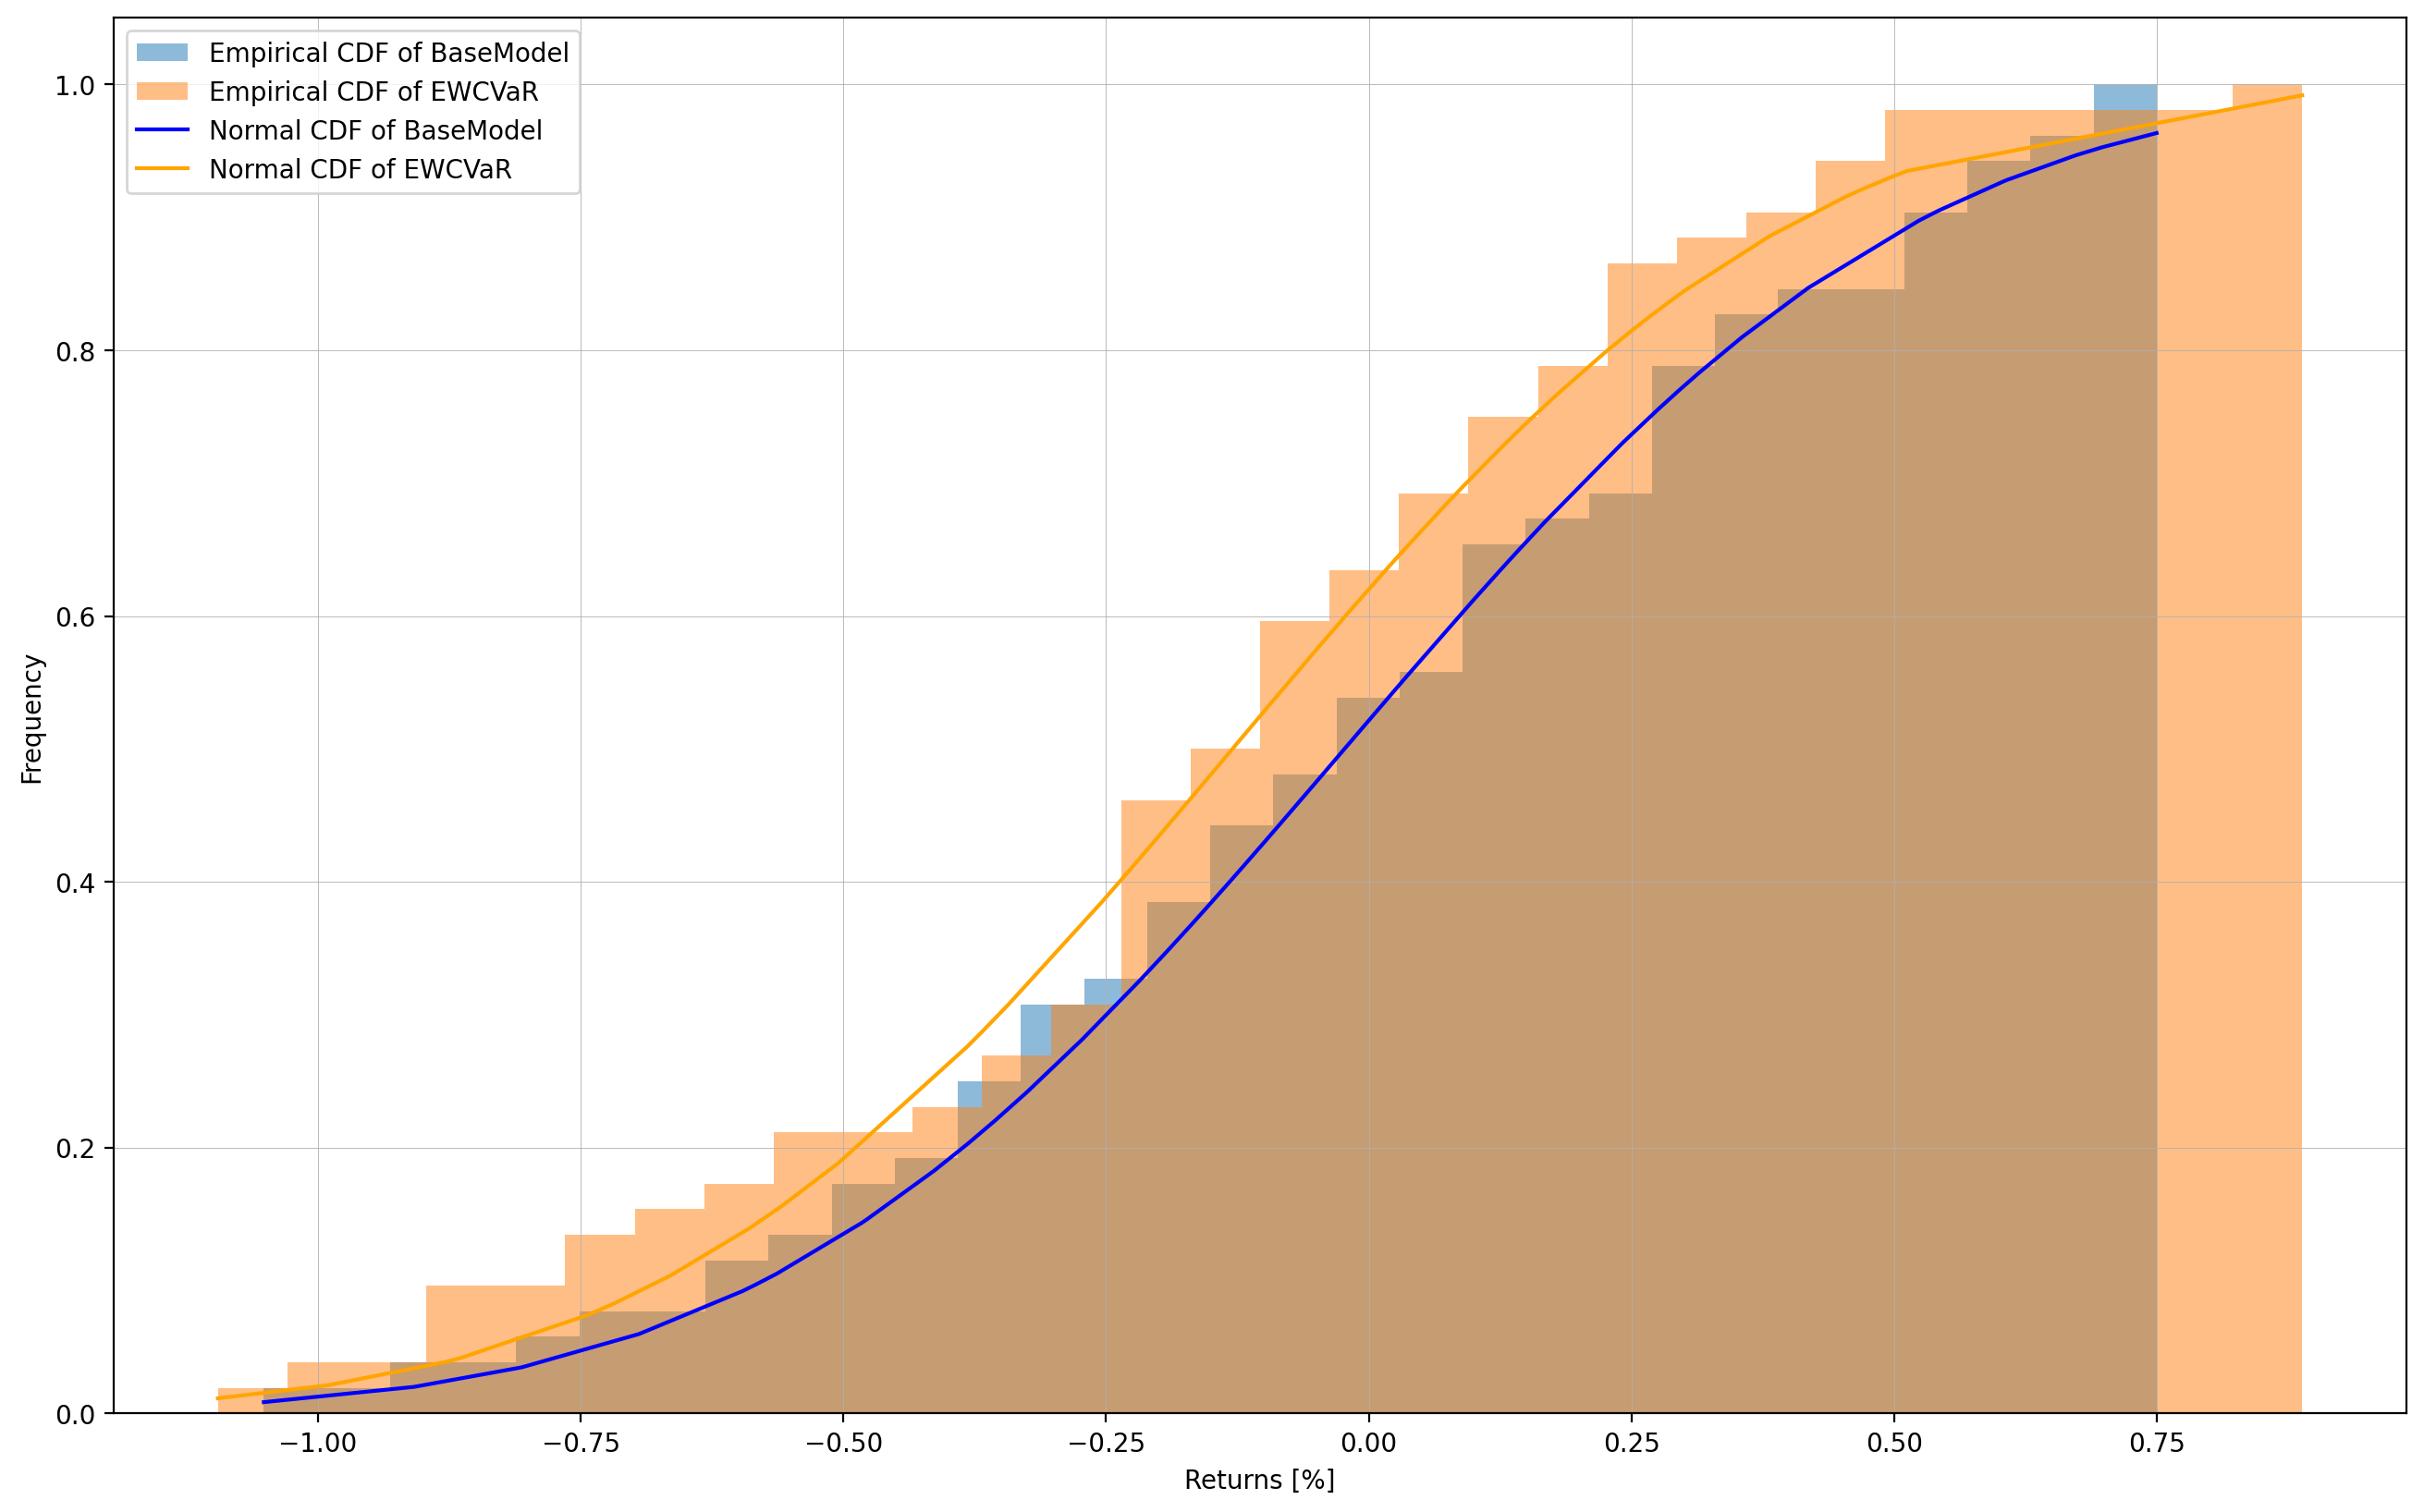

In [17]:
testEnvironmentOoS.compareDistributions('BaseModel', 'EWCVaR', fileName="Comparison_BaseModel_EWCVaR_{}".format(whichData))

# Quantitative Comparison

In [20]:
# Create a comparison environment
quantitativeComparison = PerformanceMetrics(portfolios, assets, index, enhancedIndex, dataSet="GMS-{}".format(whichData));

In [21]:
results = quantitativeComparison.printMetrics(enhanced=False);

\begin{tabular}{lrrr}
\toprule
{} &  BaseModel &  BaseModelDRO &  EWCVaR \\
\midrule
DownsideSemiStandardDeviation &     0.3745 &        0.7164 &  0.7932 \\
RMSE                          &     0.4516 &        0.8374 &  0.9716 \\
ExcessReturnAverage           &    -5.6577 &       -9.3345 & -2.7698 \\
ExcessReturn                  &    -5.3225 &       -8.3870 & -2.1039 \\
SortinoIndex                  &    -0.0020 &       -0.0018 & -0.0005 \\
BeatBenchmarkRatio            &    46.1538 &       51.9231 & 53.8462 \\
TotalReturn                   &    38.2789 &       35.2143 & 41.4975 \\
AverageReturn                 &    40.2617 &       36.5848 & 43.1495 \\
\bottomrule
\end{tabular}



/Users/andreasengly/Documents/Danmarks Tekniske Universitet/MSc. in Mathematical Modelling and Computation/5. semester (Thesis)/Enhanced Index Tracking/EITP/Backtesting/QuantitativeComparison.py:104: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(result).to_latex(float_format="%.4f"));


In [22]:
results['EWCVaR']

{'DownsideSemiStandardDeviation': 0.7931923081502679,
 'RMSE': 0.9715627932795892,
 'ExcessReturnAverage': -2.769834318558331,
 'ExcessReturn': -2.1039284473113753,
 'SortinoIndex': -0.0004679397015472822,
 'BeatBenchmarkRatio': 53.84615384615385,
 'TotalReturn': 41.49745452890983,
 'AverageReturn': 43.14952259200104}